# Analysis with Ensemble Methods

In this botebook, I will anlyze the data using the Decision Trees.

## Load Libraries

In [4]:
# Import base libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## Load Data

There are five data files: 
    * data1, 1year.arff 
    * data2, 2year.arff 
    * data3, 3year.arff
    * data4, 4year.arff
    * data5, 5year.arff

Initially, I will explore the models on data3. After determing the final model design, I will apply it on other datasets and compare te results.

I will use previously cleaned data, where missing values are handled.


In [5]:
# Load Clean Data (no missing values)

df3 = pd.read_csv('data/data3_noMiss.csv')
df3.head()

,Attr1,Attr2,Attr3,Attr4,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,...,Attr50,Attr51,Attr55,Attr56,Attr57,Attr58,Attr59,Attr62,Attr63,class
0,0.174190,0.41299,0.14371,1.3480,0.60383,0.219460,1.1225,1.1961,0.46359,0.219460,...,1.3480,0.41299,127280.0,0.163960,0.375740,0.83604,0.000007,84.291,4.3303,0
1,0.146240,0.46038,0.28230,1.6294,0.00000,0.171850,1.1721,1.6018,0.53962,0.175790,...,1.5874,0.44849,3387.8,0.027516,0.271000,0.90108,0.000000,102.190,3.5716,0
2,0.000595,0.22612,0.48839,3.1599,0.19114,0.004572,2.9881,1.0077,0.67566,0.004572,...,3.1599,0.22612,20453.0,0.007639,0.000881,0.99236,0.000000,64.846,5.6287,0
3,0.024526,0.43236,0.27546,1.7833,0.56944,0.024526,1.3057,1.0509,0.56453,0.024526,...,1.4504,0.35164,5012.6,0.048398,0.043445,0.95160,0.142980,98.783,3.6950,0
4,0.188290,0.41504,0.34231,1.9279,0.00000,0.233580,1.4094,1.3393,0.58496,0.238810,...,1.7136,0.36891,13730.0,0.176480,0.321880,0.82635,0.073039,100.540,3.6303,0


In [6]:
df3.shape

(10445, 49)

## Pre-process

In [7]:
# Assign target and predictor
y = df3['class']
X = df3.drop('class', axis=1)

In [8]:
# Sepearate data into train and test splist

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (8356, 48)
y_train shape =  (8356,)
X_test shape =  (2089, 48)
y_test shape =  (2089,)


In [9]:
# Scale/Normalize the predictor variables

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Convert to Dataframe
#X_train = pd.DataFrame(X_train, columns=X.columns)
#X_test = pd.DataFrame(X_test, columns=X.columns)
#X_train.head()

### Class imbalance and Resampling

In [10]:
print('Original whole data class distribution:')
print(y.value_counts())
print('Original whole data class distribution, normalized:')
print(y.value_counts(normalize=True))

Original whole data class distribution:
0    9954
1     491
Name: class, dtype: int64
Original whole data class distribution, normalized:
0    0.952992
1    0.047008
Name: class, dtype: float64


In [11]:
#Resample

smote = SMOTE()
X_train_rs, y_train_rs = smote.fit_resample(X_train, y_train)

print('Original training data class distribution:')
print(pd.Series(y_train).value_counts())

print('Synthetic training data class distribution:')
print(pd.Series(y_train_rs).value_counts())

Original training data class distribution:
0    7961
1     395
dtype: int64
Synthetic training data class distribution:
1    7961
0    7961
dtype: int64


## Baseline Model - XGBoost

In [12]:
# Instantiate, fit XGBClassifier on NOT resampled data

xgb = XGBClassifier(random_state=42, eval_metric='logloss') #'logloss' is default, but specified to stop warning
xgb.fit(X_train, y_train)

print('Data3, NOT Resampled:\n')
print('Training Data:\n', classification_report(y_train, xgb.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3, NOT Resampled:

Training Data:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      7961
           1       1.00      0.08      0.15       395

    accuracy                           0.96      8356
   macro avg       0.98      0.54      0.57      8356
weighted avg       0.96      0.96      0.94      8356

Testing Data:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1993
           1       1.00      0.04      0.08        96

    accuracy                           0.96      2089
   macro avg       0.98      0.52      0.53      2089
weighted avg       0.96      0.96      0.94      2089



In [13]:
# Instantiate, fit XGBClassifier on resampled data

xgb = XGBClassifier(random_state=42, eval_metric='logloss') #'logloss' is default, but specified to stop warning
xgb.fit(X_train_rs, y_train_rs)

print('Data3, Resampled training:\n')
print('Training Data:\n', classification_report(y_train_rs, xgb.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3, Resampled training:

Training Data:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      7961
           1       0.85      0.92      0.88      7961

    accuracy                           0.88     15922
   macro avg       0.88      0.88      0.88     15922
weighted avg       0.88      0.88      0.88     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      1993
           1       0.13      0.57      0.21        96

    accuracy                           0.80      2089
   macro avg       0.55      0.69      0.55      2089
weighted avg       0.94      0.80      0.86      2089



In [14]:
# Function for drawing ROC curve for train and test data

def ROC_curve_train_test(model, model_name):
    
    fig, ax = plt.subplots(figsize=(10, 8))

    #model.fit(X_train_rs, y_train_rs)
      
    y_train_pred = model.predict(X_train_rs)   
    y_train_prob = model.predict_proba(X_train_rs) #Probability estimates for each class
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rs, y_train_prob[:,1])
    auc_train = round(auc(fpr_train, tpr_train),3)
    f1_train = round(f1_score(y_train_rs, y_train_pred),3)
    recall_train = round(recall_score(y_train_rs, y_train_pred),3)
    precision_train = round(precision_score(y_train_rs, y_train_pred),3)
    accuracy_train = round(accuracy_score(y_train_rs, y_train_pred),3)
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train: acc={accuracy_train}, prec={precision_train}, rec={recall_train}, f1={f1_train}, AUC={auc_train}')
    #ax.plot(fpr_train, tpr_train, lw=2, label=f'Train: AUC={auc_train}')
    
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test) #Probability estimates for each class
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob[:,1])
    auc_test = round(auc(fpr_test, tpr_test),3)
    f1_test = round(f1_score(y_test, y_test_pred),3)
    recall_test = round(recall_score(y_test, y_test_pred),3)
    precision_test = round(precision_score(y_test, y_test_pred),3)
    accuracy_test = round(accuracy_score(y_test, y_test_pred),3)
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test: acc={accuracy_test}, prec={precision_test}, rec={recall_test}, f1={f1_test}, AUC={auc_test}')
    #ax.plot(fpr_test, tpr_test, lw=2, label=f'Test: AUC={auc_test}')
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_yticks([i/20.0 for i in range(21)])
    ax.set_xticks([i/20.0 for i in range(21)])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=14)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=14)
    ax.set_title(f'ROC Curve for {model_name}', fontsize=14)
    ax.legend(loc='auto', fontsize=13)
    
    plt.savefig(f'figures/ROC_Curve_{model_name}.png')


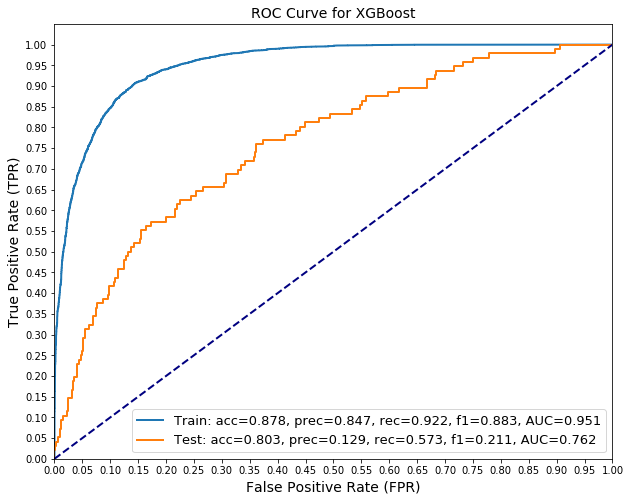

In [15]:
ROC_curve_train_test(xgb, 'XGBoost')

**Comments**

* Overall, the baseline model performance is not very good. There is a huge overfitting.
* The model performance in identfying the non-bankruptcy companies (class 0) is good. However, it fails to identify the bankruptcy companies (class 1).
* Resampling clearly increased the model performance.

### Data after Ouliers removed

At this point, it is not clear to me how significant outliers for the classification. 
Therefore, I would like to see the performance of the model after removing outliers.

In [16]:
df3_noOut = pd.read_csv('data/data3_noMiss_noOut.csv')

y_noOut = df3_noOut['class']
X_noOut = df3_noOut.drop('class', axis=1)

X_train_noOut, X_test_noOut, y_train_noOut, y_test_noOut = train_test_split(X_noOut, y_noOut, test_size=0.20, 
                                                                            random_state=42)

scaler_noOut = StandardScaler()
X_train_noOut = scaler_noOut.fit_transform(X_train_noOut)
X_test_noOut = scaler_noOut.transform(X_test_noOut)

smote_noOut = SMOTE()
X_train_rs_noOut, y_train_rs_noOut = smote_noOut.fit_resample(X_train_noOut, y_train_noOut)

In [17]:
xgb_noOut = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_noOut.fit(X_train_rs_noOut, y_train_rs_noOut)

print('Data3, resampled training, Outliers removed:\n')
print('Training Data:\n', classification_report(y_train_rs_noOut, xgb_noOut.predict(X_train_rs_noOut)))
print('Testing Data:\n', classification_report(y_test_noOut, xgb_noOut.predict(X_test_noOut)))

Data3, resampled training, Outliers removed:

Training Data:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      7627
           1       0.84      0.91      0.87      7627

    accuracy                           0.87     15254
   macro avg       0.87      0.87      0.87     15254
weighted avg       0.87      0.87      0.87     15254

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      1901
           1       0.16      0.63      0.26        98

    accuracy                           0.82      1999
   macro avg       0.57      0.73      0.58      1999
weighted avg       0.94      0.82      0.87      1999



**Comments**
* Removing outliers decreased the overfitting a bit and increased the overall performance on testing data a little.
* I decided not to remove the outliers in my analysis. I will leave the model to handle the outliers.

## Parameter Tuning XGBoost

I will use GridSearchCV to determine the optimum parameters.

In [393]:
# Default Parameters of XGBoostClassifier
XGBClassifier().get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>

In [392]:
# Tuning XGBClassifier with GridSearchCV

start=datetime.now()

xgb_param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],  # default: 0.1
    'max_depth': [3, 4, 5, 6], # default: 3
    'min_child_weight': [1, 2], #default: 1
    'subsample': [0.5, 0.7, 1.0], #default: 1
    'n_estimators': [50, 100], #default: 100
}

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_gs = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='accuracy')
xgb_gs.fit(X_train_rs, y_train_rs)

print('Data 3, XGboost, Parameter Tuning Results:\n')
print("Best Parameter Combination:", xgb_gs.best_params_)
print('Training Data:\n', classification_report(y_train_rs, xgb_gs.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, xgb_gs.predict(X_test)))

end=datetime.now()

print('Process time:', end-start)

Data 3, XGboost, Parameter Tuning Results:

Best Parameter Combination: {'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7961
           1       1.00      1.00      1.00      7961

    accuracy                           1.00     15922
   macro avg       1.00      1.00      1.00     15922
weighted avg       1.00      1.00      1.00     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1993
           1       0.30      0.32      0.31        96

    accuracy                           0.93      2089
   macro avg       0.63      0.64      0.64      2089
weighted avg       0.94      0.93      0.93      2089

Process time: 0:39:48.923302


**Comments**
* Overall Model performance is improved after parameter tuning.
* Only, recall value for class 1 dropped.
* The overfitting increased, possibly due to increased max_depth.
* All optimum parameters, except max_depth, are same as default values.

### max_depth Tuning

Max_depth is a possible reason for ovefitting.

I will fit the model with several max_depts to find the optimal performance.

Default is max_depth = 3

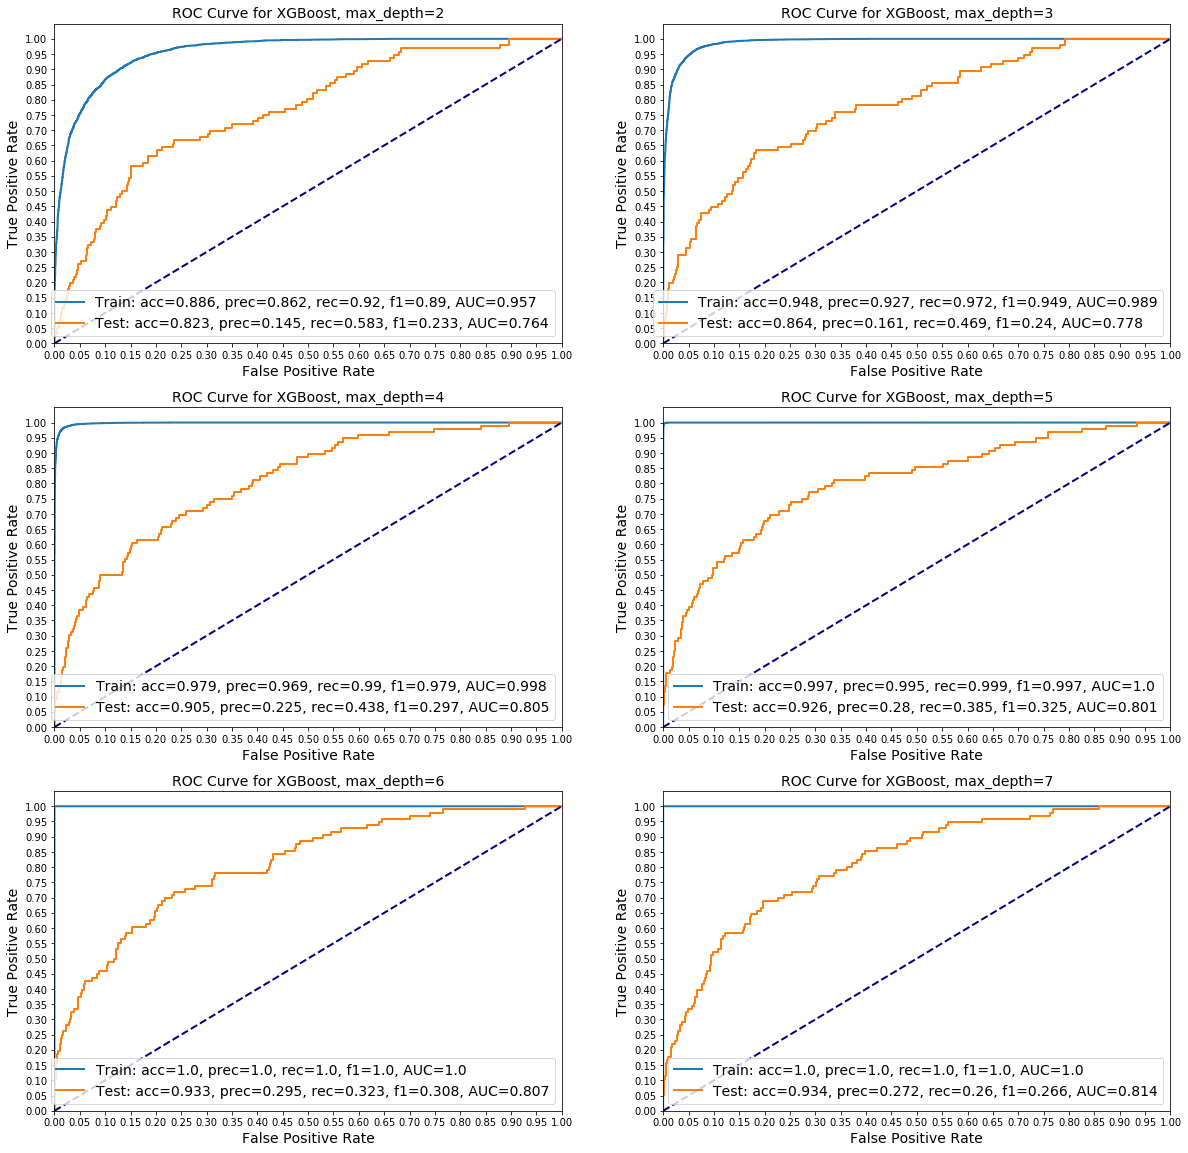

In [394]:
# Tune max_depth

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
#plt.tight_layout(pad=5)

depths = [2, 3, 4, 5, 6, 7]

for ax, d in zip(axes.flat, depths):
     
    clf = XGBClassifier(learning_rate=0.3, max_depth=d, min_child_weight=1, n_estimators=100, \
                        subsample=1, eval_metric='logloss', random_state=42)
        
    clf.fit(X_train_rs, y_train_rs)
    
    y_train_pred = clf.predict(X_train_rs)   
    y_train_prob = clf.predict_proba(X_train_rs) #Probability estimates for each class
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rs, y_train_prob[:,1])
    auc_train = round(auc(fpr_train, tpr_train),3)
    f1_train = round(f1_score(y_train_rs, y_train_pred),3)
    recall_train = round(recall_score(y_train_rs, y_train_pred),3)
    precision_train = round(precision_score(y_train_rs, y_train_pred),3)
    accuracy_train = round(accuracy_score(y_train_rs, y_train_pred),3)
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train: acc={accuracy_train}, prec={precision_train}, rec={recall_train}, f1={f1_train}, AUC={auc_train}')
    
    y_test_pred = clf.predict(X_test)
    y_test_prob = clf.predict_proba(X_test) #Probability estimates for each class
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob[:,1])
    auc_test = round(auc(fpr_test, tpr_test),3)
    f1_test = round(f1_score(y_test, y_test_pred),3)
    recall_test = round(recall_score(y_test, y_test_pred),3)
    precision_test = round(precision_score(y_test, y_test_pred),3)
    accuracy_test = round(accuracy_score(y_test, y_test_pred),3)
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test: acc={accuracy_test}, prec={precision_test}, rec={recall_test}, f1={f1_test}, AUC={auc_test}')  
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_yticks([i/20.0 for i in range(21)])
    ax.set_xticks([i/20.0 for i in range(21)])
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title(f'ROC Curve for XGBoost, max_depth={d}', fontsize=14)
    ax.legend(loc='lower right', fontsize=14)
    
plt.savefig(f'figures/ROC_Curve_XGBoost_maxDepth.png')


**Comments**

* As max_depth increases, overfitting increases.
* As max_depth increases, model performance on testing data increases.
* I will choose the max_depth=6.

### learning_rate Tuning

Learning_rate is another reason for ovefitting.

I will fit the model with several learning_rate to find the optimal performance.

Default is learning_rate = 0.1

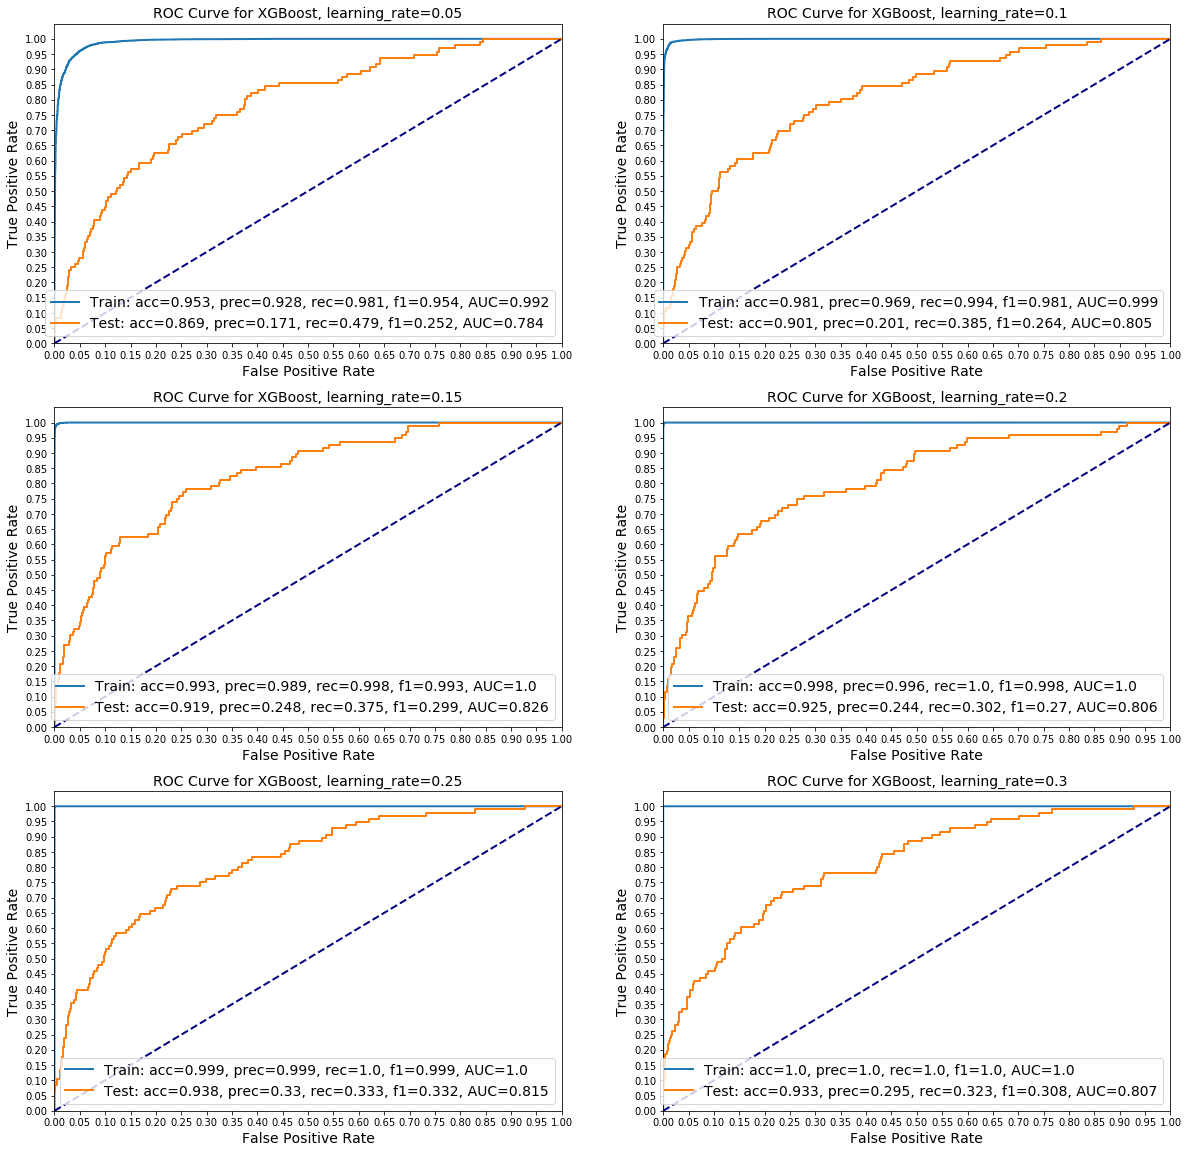

In [412]:
# Tune learning_rate

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
#plt.tight_layout(pad=5)

rates = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

for ax, d in zip(axes.flat, rates):
     
    clf = XGBClassifier(learning_rate=d, max_depth=6, min_child_weight=1, n_estimators=100, \
                        subsample=1, eval_metric='logloss', random_state=42)
        
    clf.fit(X_train_rs, y_train_rs)
    
    y_train_pred = clf.predict(X_train_rs)   
    y_train_prob = clf.predict_proba(X_train_rs) #Probability estimates for each class
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rs, y_train_prob[:,1])
    auc_train = round(auc(fpr_train, tpr_train),3)
    f1_train = round(f1_score(y_train_rs, y_train_pred),3)
    recall_train = round(recall_score(y_train_rs, y_train_pred),3)
    precision_train = round(precision_score(y_train_rs, y_train_pred),3)
    accuracy_train = round(accuracy_score(y_train_rs, y_train_pred),3)
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train: acc={accuracy_train}, prec={precision_train}, rec={recall_train}, f1={f1_train}, AUC={auc_train}')
    
    y_test_pred = clf.predict(X_test)
    y_test_prob = clf.predict_proba(X_test) #Probability estimates for each class
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob[:,1])
    auc_test = round(auc(fpr_test, tpr_test),3)
    f1_test = round(f1_score(y_test, y_test_pred),3)
    recall_test = round(recall_score(y_test, y_test_pred),3)
    precision_test = round(precision_score(y_test, y_test_pred),3)
    accuracy_test = round(accuracy_score(y_test, y_test_pred),3)
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test: acc={accuracy_test}, prec={precision_test}, rec={recall_test}, f1={f1_test}, AUC={auc_test}')  
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_yticks([i/20.0 for i in range(21)])
    ax.set_xticks([i/20.0 for i in range(21)])
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title(f'ROC Curve for XGBoost, learning_rate={d}', fontsize=14)
    ax.legend(loc='lower right', fontsize=14)
    
plt.savefig(f'figures/ROC_Curve_XGBoost_LearningRate.png')


**Comments**

* Overfitting increases as learning_rate increases.
* Model performance increases as learning_rate increases.
* Optimum Learning_rate=0.25

## Regularization

I will use regularization parameters to decrease the overfitting.

I will test both L1 and L2 regularizations with various parameters.

Default regualrization parameters for XGBTClassifier: reg_lambda=1, reg_alpha=0

In [413]:
XGBClassifier(random_state=42, eval_metric='logloss', max_depth=6).get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>

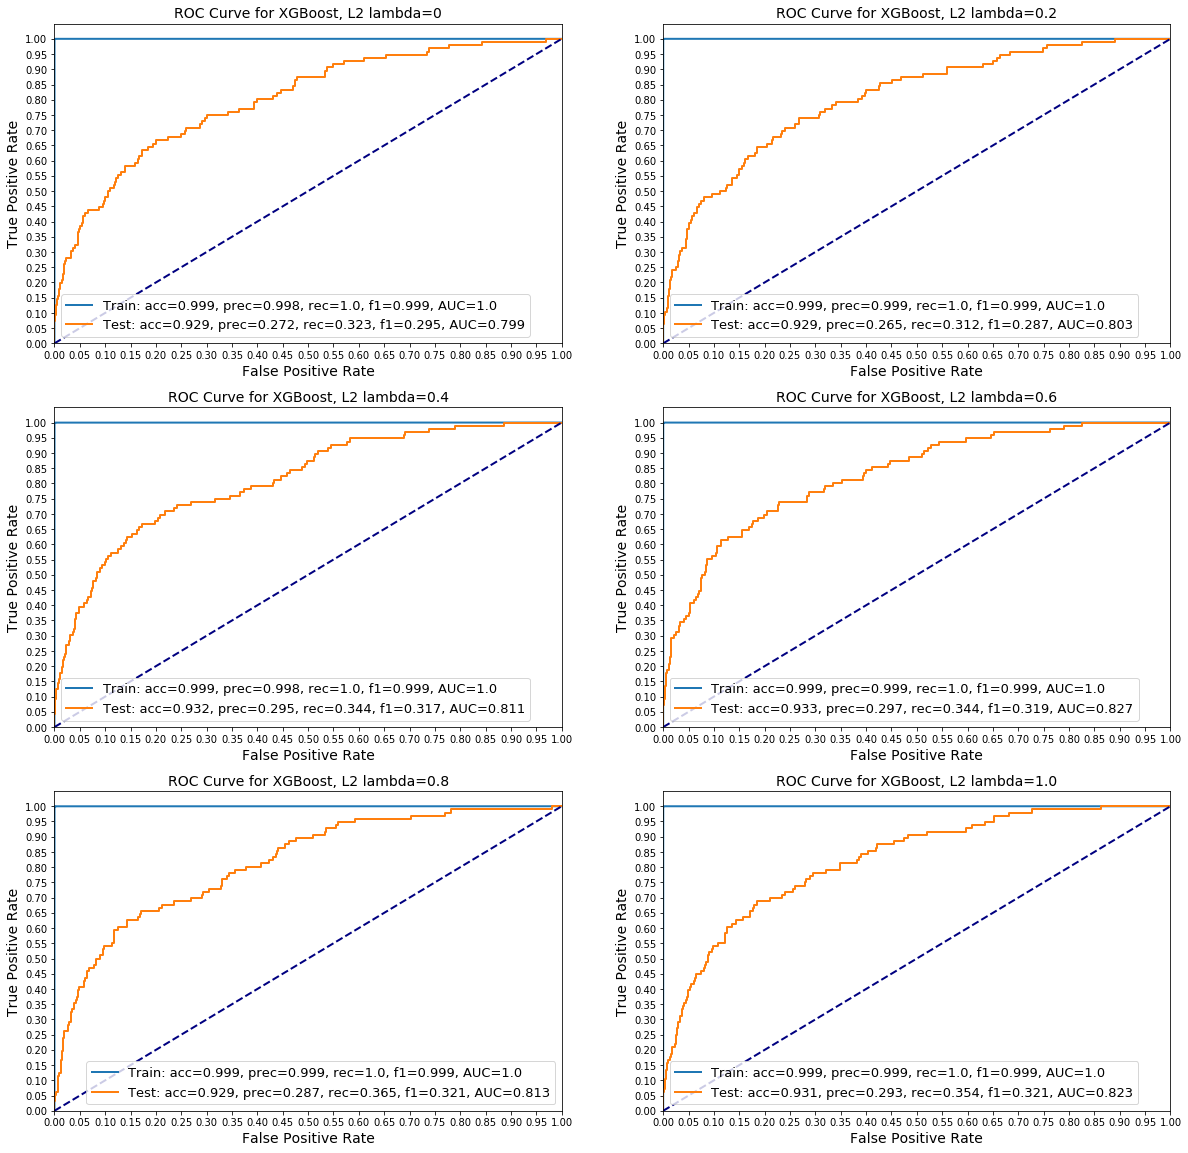

In [458]:
# Test the L2 regualarization parameters

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
#plt.tight_layout(pad=5)

#Defualt: reg_lambda:1, reg_alpha:0

reg_lambda = [0, .2, .4, .6, .8, 1.0]  #L2 regularization

for ax, reg in zip(axes.flat, reg_lambda):
    
    clf = XGBClassifier(learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=100, \
                        subsample=1, eval_metric='logloss', random_state=42, \
                       reg_lambda=reg, reg_alpha=0)


    clf.fit(X_train_rs, y_train_rs)
    
    y_train_pred = clf.predict(X_train_rs)   
    y_train_prob = clf.predict_proba(X_train_rs) #Probability estimates for each class
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rs, y_train_prob[:,1])
    auc_train = round(auc(fpr_train, tpr_train),3)
    f1_train = round(f1_score(y_train_rs, y_train_pred),3)
    recall_train = round(recall_score(y_train_rs, y_train_pred),3)
    precision_train = round(precision_score(y_train_rs, y_train_pred),3)
    accuracy_train = round(accuracy_score(y_train_rs, y_train_pred),3)
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train: acc={accuracy_train}, prec={precision_train}, rec={recall_train}, f1={f1_train}, AUC={auc_train}')
    
    y_test_pred = clf.predict(X_test)
    y_test_prob = clf.predict_proba(X_test) #Probability estimates for each class
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob[:,1])
    auc_test = round(auc(fpr_test, tpr_test),3)
    f1_test = round(f1_score(y_test, y_test_pred),3)
    recall_test = round(recall_score(y_test, y_test_pred),3)
    precision_test = round(precision_score(y_test, y_test_pred),3)
    accuracy_test = round(accuracy_score(y_test, y_test_pred),3)
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test: acc={accuracy_test}, prec={precision_test}, rec={recall_test}, f1={f1_test}, AUC={auc_test}')
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_yticks([i/20.0 for i in range(21)])
    ax.set_xticks([i/20.0 for i in range(21)])
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title(f'ROC Curve for XGBoost, L2 lambda={reg}', fontsize=14)
    ax.legend(loc='auto', fontsize=13)
    
plt.savefig(f'figures/ROC_Curve_XGBoost_L2reg.png')


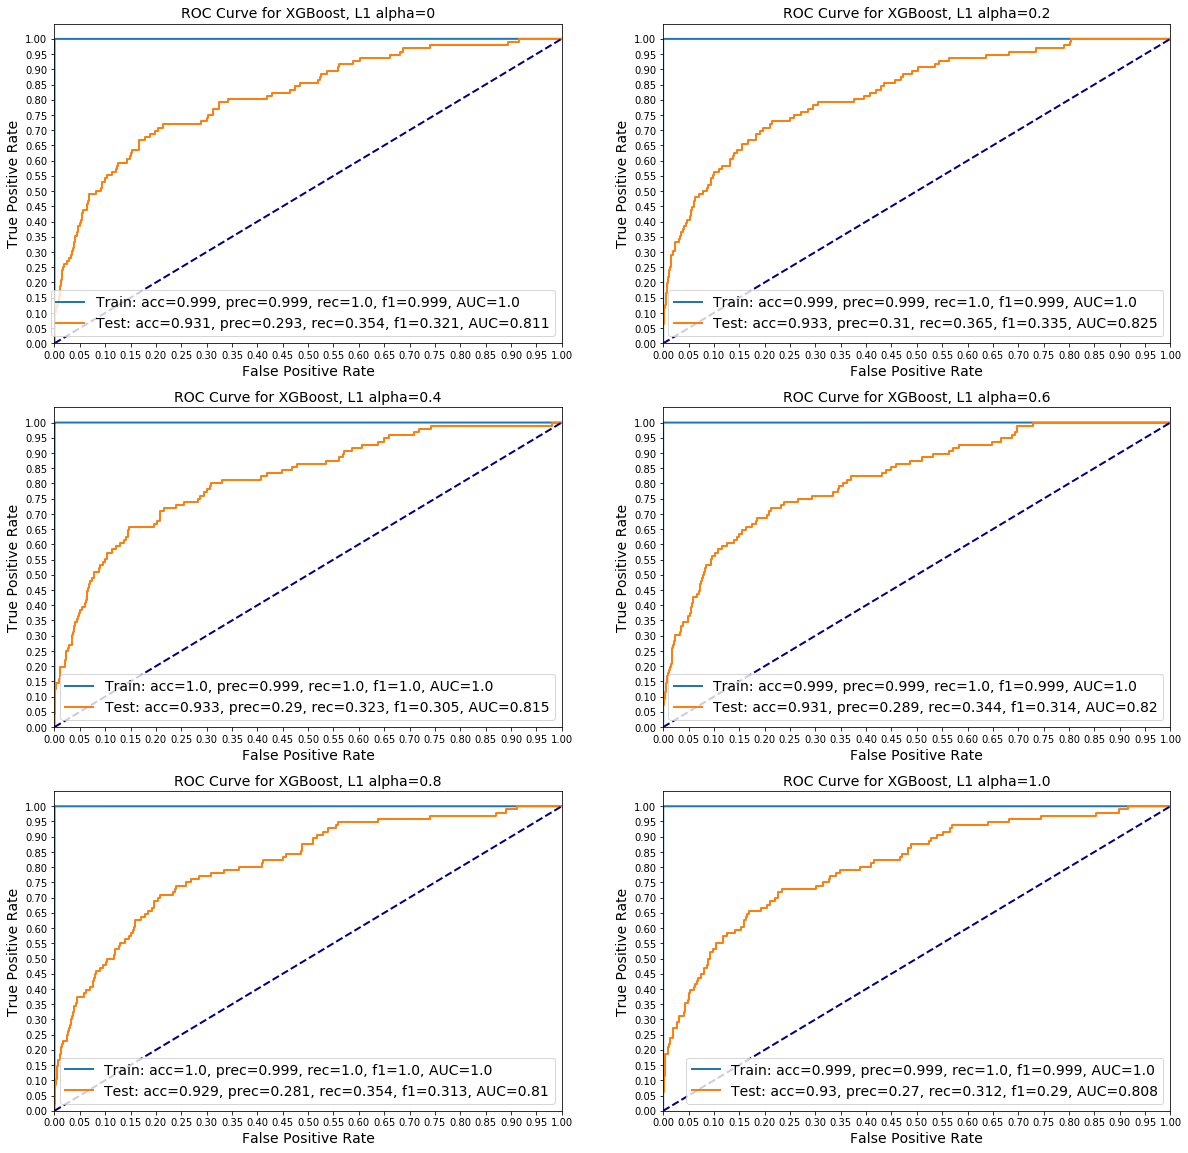

In [415]:
# Test the L1 regualarization parameters

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
#plt.tight_layout(pad=5)

#Defualt: reg_lambda:1, reg_alpha:0

reg_alpha = [0, .2, .4, .6, .8,  1.0]  #L1 regularization

for ax, reg in zip(axes.flat, reg_alpha):
    
    clf = XGBClassifier(learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=100, \
                        subsample=1, eval_metric='logloss', random_state=42, \
                       reg_lambda=0, reg_alpha=reg)

    clf.fit(X_train_rs, y_train_rs)
    
    y_train_pred = clf.predict(X_train_rs)   
    y_train_prob = clf.predict_proba(X_train_rs) #Probability estimates for each class
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rs, y_train_prob[:,1])
    auc_train = round(auc(fpr_train, tpr_train),3)
    f1_train = round(f1_score(y_train_rs, y_train_pred),3)
    recall_train = round(recall_score(y_train_rs, y_train_pred),3)
    precision_train = round(precision_score(y_train_rs, y_train_pred),3)
    accuracy_train = round(accuracy_score(y_train_rs, y_train_pred),3)
    ax.plot(fpr_train, tpr_train, lw=2, label=f'Train: acc={accuracy_train}, prec={precision_train}, rec={recall_train}, f1={f1_train}, AUC={auc_train}')
    
    y_test_pred = clf.predict(X_test)
    y_test_prob = clf.predict_proba(X_test) #Probability estimates for each class
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob[:,1])
    auc_test = round(auc(fpr_test, tpr_test),3)
    f1_test = round(f1_score(y_test, y_test_pred),3)
    recall_test = round(recall_score(y_test, y_test_pred),3)
    precision_test = round(precision_score(y_test, y_test_pred),3)
    accuracy_test = round(accuracy_score(y_test, y_test_pred),3)
    ax.plot(fpr_test, tpr_test, lw=2, label=f'Test: acc={accuracy_test}, prec={precision_test}, rec={recall_test}, f1={f1_test}, AUC={auc_test}')
    
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_yticks([i/20.0 for i in range(21)])
    ax.set_xticks([i/20.0 for i in range(21)])
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title(f'ROC Curve for XGBoost, L1 alpha={reg}', fontsize=14)
    ax.legend(loc='lower right', fontsize=14)
    
plt.savefig(f'figures/ROC_Curve_XGBoost_L1reg.png')


**Comments**
* Regularization do have very small effect.
* The regularization effects are very similar
* Therefore, I keep the default regularization
    * L2 with reg_lambda=1

* Optimum parameters:
    * learning_rate=0.25, 
    * max_depth=6, 
    * min_child_weight=1, 
    * n_estimators=100, 
    * subsample=1
    * reg_lambda=1
    * reg_alpha=0

## Final XGBoost Model

In [18]:
# Run the final model with optimum parameters:

#xgb_final = XGBClassifier(learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=100, subsample=1, eval_metric='logloss', random_state=42, reg_lambda=1, reg_alpha=0)

xgb_final = XGBClassifier(learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=100, \
                        subsample=1, eval_metric='logloss', random_state=42, \
                       reg_lambda=1.0, reg_alpha=0)

xgb_final.fit(X_train_rs, y_train_rs)

print('Data3 Resampled, with Tuned Parameters:\n')
print('Training Data:\n', classification_report(y_train_rs, xgb_final.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, xgb_final.predict(X_test)))


Data3 Resampled, with Tuned Parameters:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7961
           1       1.00      1.00      1.00      7961

    accuracy                           1.00     15922
   macro avg       1.00      1.00      1.00     15922
weighted avg       1.00      1.00      1.00     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      1993
           1       0.29      0.34      0.32        96

    accuracy                           0.93      2089
   macro avg       0.63      0.65      0.64      2089
weighted avg       0.94      0.93      0.93      2089



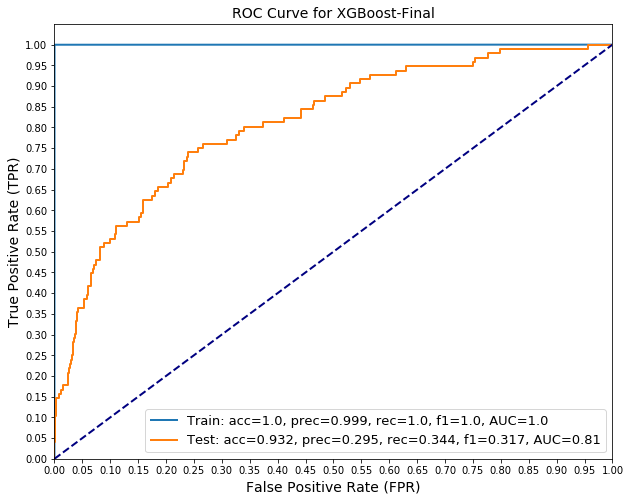

In [19]:
ROC_curve_train_test(xgb_final, 'XGBoost-Final')

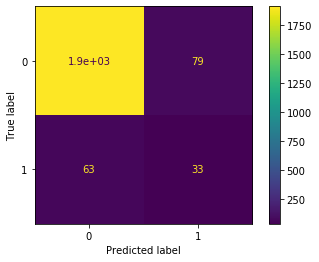

In [29]:
plot_confusion_matrix(xgb_final, X_test, y_test)
plt.savefig('figures/confusion_matrix_XGB-final.png')

In [39]:
xgb_final.save_model('saved_model_history/xgb_final.json')
# model.load_model('saved_model_history/xgb_final.json')

## Other Classification Models

The performance for the XGboost is not very good.
I would like to try other models.

### Logistic Regression

In [31]:
## LogisticRegression

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_rs, y_train_rs)

print('Data3 Resampled, with Tuned Parameters:\n')
print('Training Data:\n', classification_report(y_train_rs, logreg.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, logreg.predict(X_test)))

Data3 Resampled, with Tuned Parameters:

Training Data:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70      7961
           1       0.70      0.79      0.74      7961

    accuracy                           0.72     15922
   macro avg       0.73      0.72      0.72     15922
weighted avg       0.73      0.72      0.72     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.67      0.79      1993
           1       0.09      0.66      0.15        96

    accuracy                           0.67      2089
   macro avg       0.53      0.66      0.47      2089
weighted avg       0.94      0.67      0.76      2089



### K-Nearest Neighbors

In [33]:
# KNeighborsClassifier, 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_rs, y_train_rs)

print('Training Data:\n', classification_report(y_train_rs, knn.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, knn.predict(X_test)))

Training Data:
               precision    recall  f1-score   support

           0       0.99      0.85      0.92      7961
           1       0.87      0.99      0.93      7961

    accuracy                           0.92     15922
   macro avg       0.93      0.92      0.92     15922
weighted avg       0.93      0.92      0.92     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.96      0.79      0.86      1993
           1       0.07      0.34      0.12        96

    accuracy                           0.77      2089
   macro avg       0.52      0.56      0.49      2089
weighted avg       0.92      0.77      0.83      2089



### Decison Trees

In [34]:
# DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_rs, y_train_rs)

print('Training Data:\n', classification_report(y_train_rs, dt.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, dt.predict(X_test)))

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7961
           1       1.00      1.00      1.00      7961

    accuracy                           1.00     15922
   macro avg       1.00      1.00      1.00     15922
weighted avg       1.00      1.00      1.00     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      1993
           1       0.10      0.26      0.15        96

    accuracy                           0.86      2089
   macro avg       0.53      0.57      0.53      2089
weighted avg       0.92      0.86      0.89      2089



### Random Forest

In [37]:
# RandomForestClassifier 

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_rs, y_train_rs) 

print('Training Data:\n', classification_report(y_train_rs, rf.predict(X_train_rs)))
print('Testing Data:\n', classification_report(y_test, rf.predict(X_test)))

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7961
           1       1.00      1.00      1.00      7961

    accuracy                           1.00     15922
   macro avg       1.00      1.00      1.00     15922
weighted avg       1.00      1.00      1.00     15922

Testing Data:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1993
           1       0.17      0.18      0.17        96

    accuracy                           0.92      2089
   macro avg       0.56      0.57      0.56      2089
weighted avg       0.92      0.92      0.92      2089

